# COVID pathway-pathway network 

The same network is constructed using pathway-level data (created using ssPA scores). The only modification required is the `pathway_level=True` argument in the MTBLSDataset class

In [1]:
# from COVID_study_processing import MTBLSDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import cmcrameri.cm as cmc
import scipy.stats as stats
from matplotlib import pyplot as plt


import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import glob
import sspa
import numbers

sns.set_theme(
    style='whitegrid',
    palette='Paired',
#     font='Arial',
)

In [2]:

class MTBLSDataset:
    '''
    Class representing a Metabolights dataset.

    Parameters:
    - file_path (str): The path to the directory containing .maf file and sample metadata file from MetaboLights
    - id (str): The MetaboLights identifier of the dataset.
    - node_name (str): node name, can be the same as id
    - md_group (str): The metadata column within the sample metadata file.
    - md_filter (dict): Dictionary specifying which metadata label is case and which is the control (e.g. {'Case':'Severe','Control': 'Mild'})
    - identifier (str, optional): The identifier column name. Defaults to 'database_identifier'.
    - remove_suffix (int, optional): The number of characters to remove from the end of the sample names. Defaults to None.
    - remove_prefix (int, optional): The number of characters to remove from the beginning of the sample names. Defaults to None.
    - outliers (list, optional): The list of sample IDs to be removed as outliers. Defaults to None.
    - pathway_level (bool, optional): Whether to perform analysis at the pathway level. Defaults to False.

    Attributes:
    - raw_data (DataFrame): The raw data from the dataset.
    - compound_mappers (None): Placeholder for DataFrame of alternative identifiers.
    - processed_data (DataFrame): The processed data from the dataset.
    - DA_metabolites (None): Placeholder for DA metabolites DataFrame containing results of DA testing.
    - pathway_data (None): Placeholder for pathway transformed data matrix.
    - pathway_coverage (None): Placeholder for pathway coverage dictionary

    Methods:
    - read_data(): Reads the data from the dataset file.
    - preprocess_data(): Preprocesses the raw data.
    - get_pathway_data(): ssPA transformation 
    - plot_qc(): Plots PCA and box plots
    - da_testing(): Performs differential analysis testing.
    '''

    def __init__(self, file_path, id, node_name, md_group, md_filter, identifier='database_identifier', remove_suffix=None, remove_prefix=None,  outliers=None, pathway_level=False):
        self.file_path = file_path
        self.raw_data = None
        self.remove_suffix = remove_suffix
        self.remove_prefix = remove_prefix
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None
        self.identifier = identifier
        self.outliers = outliers
        self.pathway_data = None
        self.pathway_level = pathway_level
        self.pathway_coverage = None

        self.read_data()
        # self.preprocess_data()
        self.get_pathway_data()
        self.da_testing()
        

    def read_data(self):
        '''
        Reads the data from the dataset file and sends it for preprocessing.

        Returns:
        - processed_data (DataFrame): The processed data from the dataset.
        - metadata (DataFrame): The metadata from the dataset.
        '''
        # check if there are multiple files in folder
        metadata = pd.read_csv(self.file_path + '/s_' + self.id + '.txt', sep = '\t', encoding='unicode_escape')

        metadata['Sample Name'] = metadata['Sample Name'].astype(str)
        if self.remove_suffix:
            metadata['Sample Name'] = metadata['Sample Name'].str[:-self.remove_suffix]
        if self.remove_prefix:
            metadata['Sample Name'] = metadata['Sample Name'].str[self.remove_prefix:]

        self.metadata = metadata

        files = glob.glob(self.file_path + '/*' + 'maf.tsv')
        if len(files) > 1:
            print(len(files), 'assay files found')
            # read in all files and concatenate
            dfs = []
            dfs_proc = []
            for f in files:
                df = pd.read_csv(f, sep='\t')
                dfs.append(df)
                # df.index = df['Samples']
                self.raw_data = df

                df_proc = self.preprocess_data()
                dfs_proc.append(df_proc)

            self.raw_data = pd.concat(dfs, axis=1)
            
            # inner join removes samples not present in all assays
            proc_data = pd.concat(dfs_proc, axis=1, join='inner')
            # aveage same columns
            proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
            # remove duplicate 'Group' columns
            proc_data = proc_data.loc[:, ~proc_data.columns.duplicated()]

            # move group column to end
            cols = [col for col in proc_data.columns if col != 'Group'] + ['Group']
            self.processed_data = proc_data[cols]

        else:
            print(len(files), 'assay file found')
            data = pd.read_csv(files[0], sep='\t')
            # data.index = data['Samples']
            self.raw_data = data

            proc_data = self.preprocess_data()
            proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
            self.processed_data = proc_data

        return self.processed_data, self.metadata


    def preprocess_data(self):
        '''
        Preprocesses the raw data (filtering, imputation, scaling).

        Returns:
        - data_scaled (DataFrame): The preprocessed and scaled data.
        '''
        data_filt = self.raw_data.copy()

        # repalce decimal in mz ratios
        try:
            data_filt['mass_to_charge'] = data_filt['mass_to_charge'].round(2)
            data_filt['mass_to_charge'] = data_filt['mass_to_charge'].astype('str').apply(lambda x: re.sub(r'\.', '_', x))
        except KeyError:
            pass

        self.all_ids = data_filt.iloc[:, ~data_filt.columns.isin(self.metadata['Sample Name'].tolist())]

        # # set chebi as index
        data_filt = data_filt[data_filt[self.identifier].notna()]

        # if there are no chebis in the whole assay file, drop it
        if data_filt.shape[0] == 0:
            print('No CHEBIS for assay')
            return None
        else:
            data_filt = data_filt[data_filt[self.identifier] != 'unknown']
            data_filt.index = data_filt[self.identifier]

            # remove assay specific sample suffixes
            if self.remove_suffix:
                data_filt.columns = data_filt.columns.str[:-self.remove_suffix]

            # keep only abundance data filtering on samples
            # store alternative identifiers in a dict
            samples = self.metadata['Sample Name'].tolist()
            ids = data_filt.iloc[:, ~data_filt.columns.isin(samples)]
            self.id_dict = ids.to_dict()
            data_filt = data_filt.iloc[:, data_filt.columns.isin(samples)]

            # ensure all data is numeric
            data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

            # Transpose
            data_filt = data_filt.T

            # There will be QC samples so better filter on metadata at this point
            md_dict = dict(zip(self.metadata['Sample Name'], self.metadata[self.md_group]))
            # add metadata column
            data_filt['Group'] = data_filt.index.map(md_dict)

            # filter on metadata
            data_filt = data_filt[data_filt['Group'].isin(self.md_filter.values())]
            data_filt = data_filt.drop(columns=['Group'])
            # drop outliers
            if self.outliers:
                data_filt = data_filt.drop(self.outliers)

            # Missingness checks 
            # replace empty strings with NaN
            data_filt = data_filt.replace(['', ' '], np.nan)
            # Delete colums and rows where all values are missing
            data_filt = data_filt.dropna(axis=0, how='all')
            data_filt = data_filt.dropna(axis=1, how='all')

            # Delete rows and columns where all values are 0 
            data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
            data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

            data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
            missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
            print(f"Missingness: {missing_pct:.2f}%")

            # impute missing values
            imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
            data_imputed = imputer.fit_transform(data_filt)

            # log transformation
            data_imputed = np.log(data_imputed + 1)

            # standardize
            scaler = StandardScaler().set_output(transform="pandas")
            data_scaled = scaler.fit_transform(data_imputed)

            data_scaled['Group'] = data_scaled.index.map(md_dict)
            self.processed_data = data_scaled

            return data_scaled
    
    def get_pathway_data(self):
        '''
        Performs ssPA pathway transformation on the data.
        '''
        reactome_paths = sspa.process_gmt(infile='Reactome_Homo_sapiens_pathways_ChEBI_R90.gmt')
        reactome_dict = sspa.utils.pathwaydf_to_dict(reactome_paths)
        # remove CHEBI: from column names
        data = self.processed_data
        data.columns = data.columns.str.removeprefix("CHEBI:")

        # store pathway coverage stats
        cvrg_dict = {k: len(set(data.columns).intersection(set(v))) for k, v in reactome_dict.items()}
        self.pathway_coverage = cvrg_dict

        scores = sspa.sspa_KPCA(reactome_paths).fit_transform(data.iloc[:, :-1])
        scores['Group'] = self.processed_data['Group']
        self.pathway_data = scores
    
    def plot_qc(self):
        '''
        Plots PCA and boxplots, returns figure
        '''
        # PCA biplot
        pca = PCA(n_components=2).set_output(transform="pandas")
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])
        self.pca = pca_result

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result.iloc[:, 0], y=pca_result.iloc[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # every nth feature - display 20 features
        feature_idx = int(self.processed_data.shape[1]/20)
        filt_features = self.processed_data.iloc[:, ::feature_idx]
        filt_features['Group'] = self.processed_data['Group']
        data_long = filt_features.melt(id_vars='Group')
        sns.boxplot(data=data_long, ax=ax2, hue='Group', x='variable', y='value')
        ax2.tick_params(axis='x', rotation=90)
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()

    def da_testing(self):
        '''
        Performs differential analysis testing, adds pval_df attribute containing results.
        '''
        if self.pathway_level == True:
            dat = self.pathway_data
        else:
            dat = self.processed_data


        # t-test for two groups
        case = self.md_filter['Case']
        control = self.md_filter['Control']
        
        stat, pvals = stats.ttest_ind(dat[dat['Group'] == case].iloc[:, :-1],
                        dat[dat['Group'] == control].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=dat.columns[:-1], columns=['P-value'])
        pval_df['Stat'] = stat
        pval_df['Direction'] = ['Up' if x > 0 else 'Down' for x in stat]
        self.pval_df = pval_df


        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['P-value'] < 0.1].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
        self.full_connection = [(self.node_name, met) for met in self.processed_data.columns[:-1]]


In [3]:
s1866 = MTBLSDataset(
    file_path = 'Studies/MTBLS1866', 
    id = 'MTBLS1866', 
    node_name = 'MTBLS1866', 
    md_group = 'Factor Value[Medical case]', 
    md_filter = {'Control': 'HEALTHY', 'Case': 'COVID-19'},
    outliers='SA 8',
    pathway_level=True)

3 assay files found
Missingness: 0.00%
Missingness: 0.00%
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_36064\2664334150.py:97: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 45


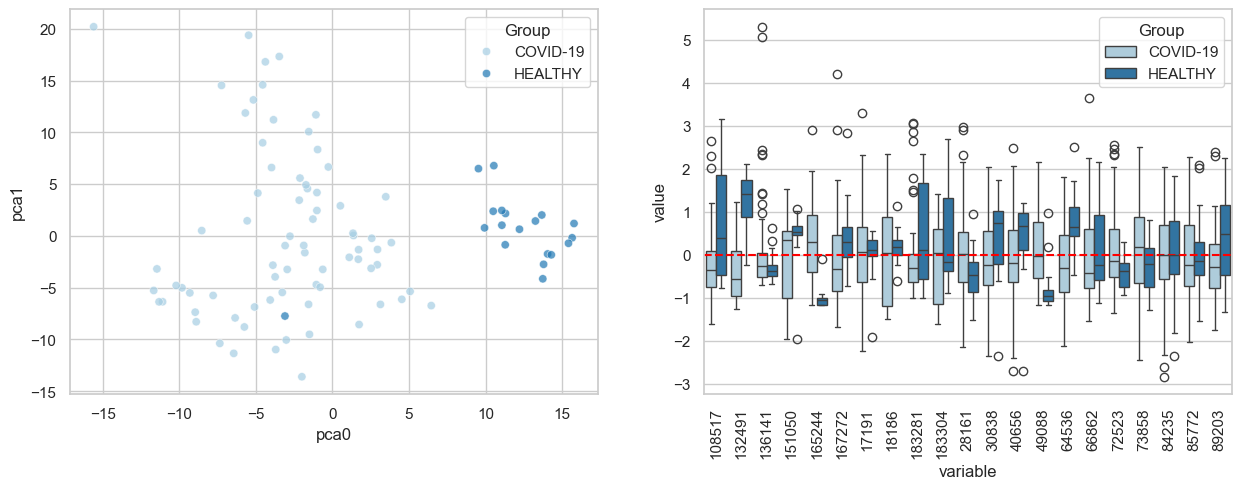

In [4]:
s1866.plot_qc()

In [5]:
s2224 = MTBLSDataset(
    file_path = 'Studies/MTBLS2224', 
    id = 'MTBLS2224', 
    node_name = 'MTBLS2224', 
    md_group = 'Factor Value[COVID Infection]', 
    md_filter = {'Case': 'Positive', 'Control': 'Negative'},
    outliers='FU22',
    pathway_level=True)

3 assay files found
Missingness: 0.00%
Missingness: 0.00%
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_36064\2664334150.py:97: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 147


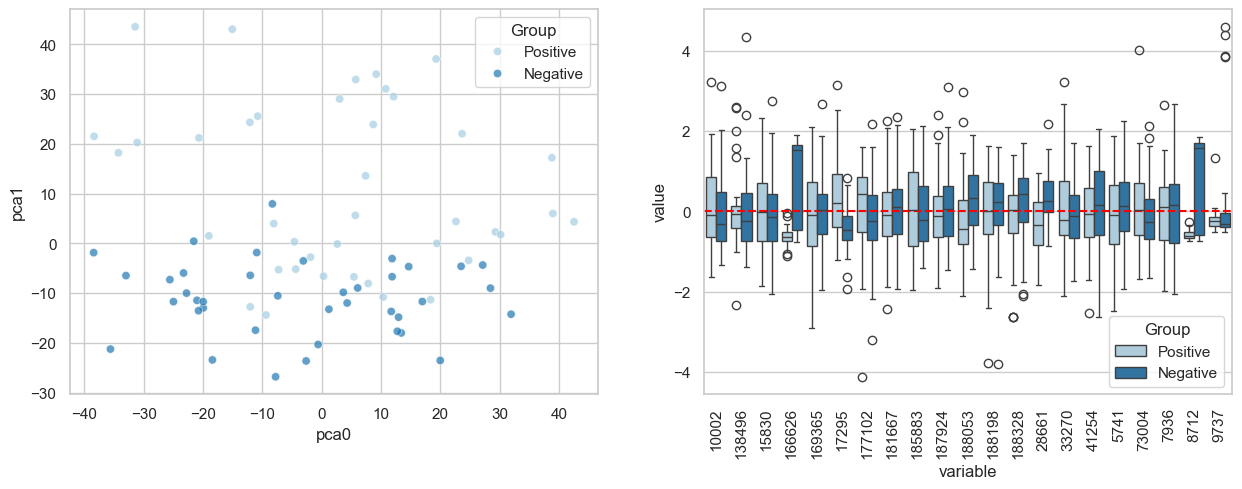

In [6]:
s2224.plot_qc()

In [7]:
s2336 = MTBLSDataset(
    file_path = 'Studies/MTBLS2336', 
    id = 'MTBLS2336', 
    node_name = 'MTBLS2336', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Case':'COVID-19', 'Control':'Healthy (control)'},
    pathway_level=True)

1 assay file found
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_36064\2664334150.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 5


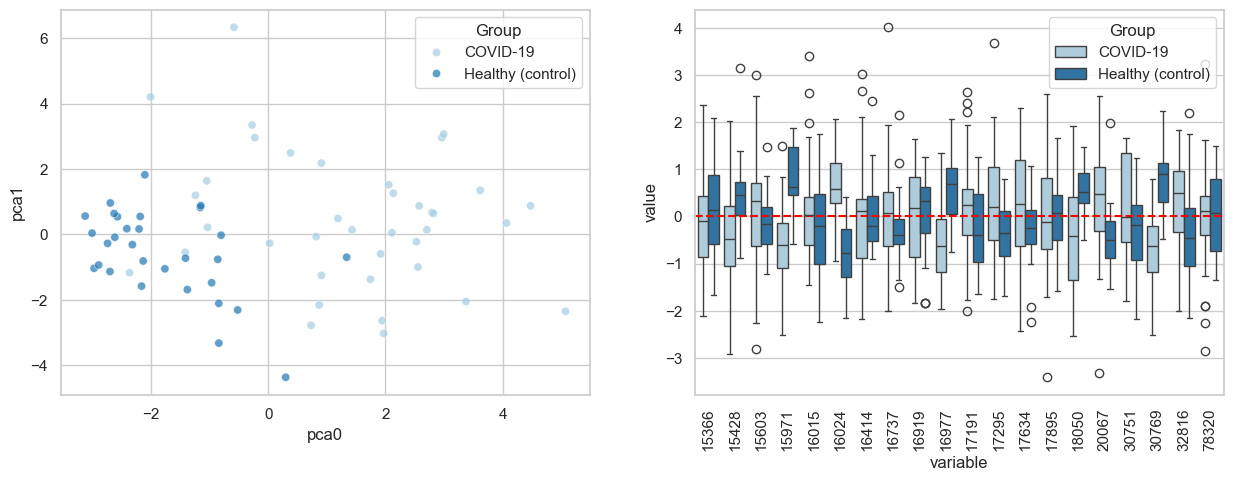

In [8]:
s2336.plot_qc()

In [9]:
s2336.pathway_data

,R-HSA-1430728,R-HSA-162582,R-HSA-212436,R-HSA-372790,R-HSA-373076,R-HSA-382551,R-HSA-388396,R-HSA-425407,R-HSA-500792,R-HSA-71291,R-HSA-73857,R-HSA-74160,Group
COVID_ANN_001,-0.030697,-0.176570,0.171363,-0.176570,-0.176570,-0.030697,-0.176570,-0.030697,-0.176570,-0.030697,0.171363,0.171363,COVID-19
COVID_ANN_002,-0.499406,-0.440733,-0.435060,-0.440733,-0.440733,-0.499406,-0.440733,-0.499406,-0.440733,-0.499406,-0.435060,-0.435060,COVID-19
COVID_ANN_003,-0.502510,-0.359049,-0.508196,-0.359049,-0.359049,-0.502510,-0.359049,-0.502510,-0.359049,-0.502510,-0.508196,-0.508196,COVID-19
COVID_ANN_004,-0.561600,-0.448076,-0.585969,-0.448076,-0.448076,-0.561600,-0.448076,-0.561600,-0.448076,-0.561600,-0.585969,-0.585969,COVID-19
COVID_ANN_005,-0.544726,-0.408592,-0.418696,-0.408592,-0.408592,-0.544726,-0.408592,-0.544726,-0.408592,-0.544726,-0.418696,-0.418696,COVID-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTR_26,-0.363656,-0.093686,-0.476247,-0.093686,-0.093686,-0.363656,-0.093686,-0.363656,-0.093686,-0.363656,-0.476247,-0.476247,Healthy (control)
CTR_27,0.010158,0.107799,0.099086,0.107799,0.107799,0.010158,0.107799,0.010158,0.107799,0.010158,0.099086,0.099086,Healthy (control)
CTR_28,0.408174,0.564370,0.193007,0.564370,0.564370,0.408174,0.564370,0.408174,0.564370,0.408174,0.193007,0.193007,Healthy (control)
CTR_29,0.477672,0.544458,0.604823,0.544458,0.544458,0.477672,0.544458,0.477672,0.544458,0.477672,0.604823,0.604823,Healthy (control)


In [10]:
s2336.pval_df

,P-value,Stat,Direction
R-HSA-1430728,0.265669,-1.122614,Down
R-HSA-162582,0.068156,-1.854364,Down
R-HSA-212436,0.108270,-1.628091,Down
R-HSA-372790,0.068156,-1.854364,Down
R-HSA-373076,0.068156,-1.854364,Down
R-HSA-382551,0.265669,-1.122614,Down
R-HSA-388396,0.068156,-1.854364,Down
R-HSA-425407,0.265669,-1.122614,Down
R-HSA-500792,0.068156,-1.854364,Down
R-HSA-71291,0.265669,-1.122614,Down


In [11]:
s2542 = MTBLSDataset(
    file_path = 'Studies/MTBLS2542', 
    id = 'MTBLS2542', 
    remove_suffix=4,
    node_name = 'MTBLS2542', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = {'Control':'Mild', 'Case':'Death'},
    pathway_level=True)

4 assay files found
No CHEBIS for assay
No CHEBIS for assay
Missingness: 0.00%
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_36064\2664334150.py:97: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 124


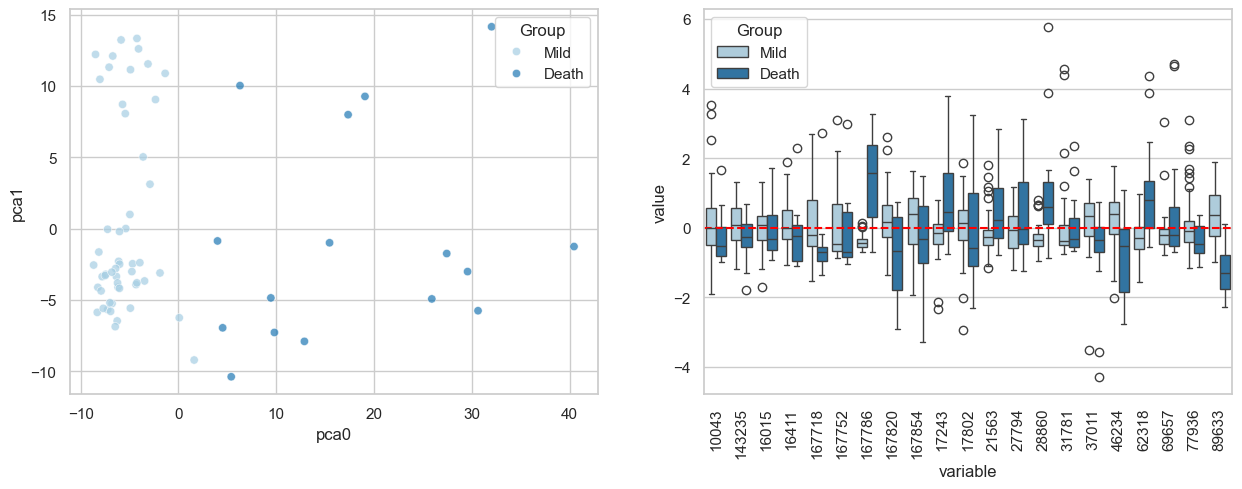

In [12]:
s2542.plot_qc()

In [13]:
s2291 = MTBLSDataset(
    file_path = 'Studies/MTBLS2291', 
    id = 'MTBLS2291', 
    node_name = 'MTBLS2291', 
    remove_prefix=9,
    md_group = 'Factor Value[Disease severity]', 
    md_filter = {'Control':'Negative COVID-19', 'Case':'Severe COVID-19'},
    outliers=['CovidNeg_P251_P_3',
 'CovidNeg_P251_P_4',
 'CovidNeg_P252_P_3',
 'CovidNeg_P252_P_4',
 'CovidNeg_P253_P_3',
 'CovidNeg_P253_P_4',
 'CovidNeg_P254_P_3',
 'CovidNeg_P254_P_4',
 'CovidNeg_P257_P_3',
 'CovidNeg_P257_P_4',
 'CovidNeg_P258_P_3',
 'CovidNeg_P258_P_4',
 'CovidNeg_P259_P_3',
 'CovidNeg_P259_P_4',
 'CovidNeg_P260_P_3',
 'CovidNeg_P260_P_4',
 'CovidNeg_P261_P_3',
 'CovidNeg_P261_P_4',
 'CovidNeg_P262_P_3',
 'CovidNeg_P262_P_4',
 'CovidNeg_P263_P_3',
 'CovidNeg_P263_P_4',
 'CovidNeg_P264_P_3',
 'CovidNeg_P264_P_4',
 'CovidNeg_P265_P_3',
 'CovidNeg_P265_P_4',
 'CovidNeg_P266_P_3',
 'CovidNeg_P266_P_4',
 'CovidNeg_P267_P_3',
 'CovidNeg_P267_P_4',
 'CovidNeg_P268_P_3',
 'CovidNeg_P268_P_4',
 'CovidNeg_P269_P_3',
 'CovidNeg_P269_P_4',
 'CovidNeg_P270_P_3',
 'CovidNeg_P270_P_4',
 'CovidNeg_P271_P_3',
 'CovidNeg_P271_P_4',
 'CovidSevere_P273_P_3',
 'CovidSevere_P273_P_4',
 'CovidSevere_P272_P_3',
 'CovidSevere_P272_P_4',
 'CovidSevere_P283_P_3',
 'CovidSevere_P283_P_4',
 'CovidSevere_P284_P_3',
 'CovidSevere_P284_P_4',
 'CovidSevere_P285_P_3',
 'CovidSevere_P285_P_4'],
    pathway_level=True
)

1 assay file found
Missingness: 18.21%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_36064\2664334150.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 9


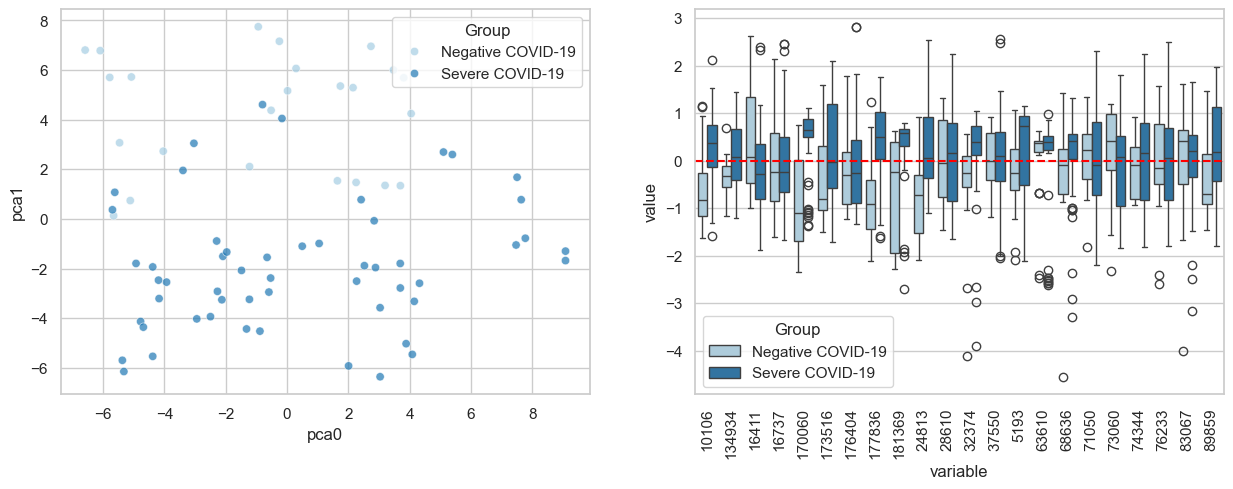

In [14]:
s2291.plot_qc()

## Differential pathways per study

In [15]:
studies = [s1866, s2224, s2542, s2291, s2336]

In [16]:
DA_res = pd.DataFrame(
    zip([len(i.DA_metabolites) for i in studies], [len(i.processed_data.columns)-1 for i in studies]),
    index=[i.node_name for i in studies],
    columns=['DA_count', 'ChEBI and Identified metabolite count']
)

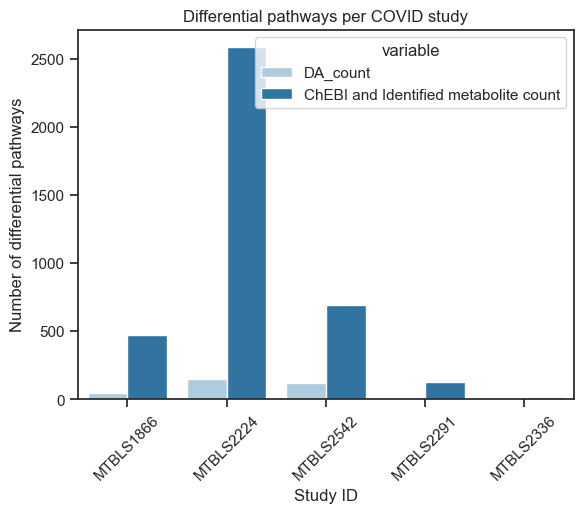

In [17]:
sns.set_style('ticks')
sns.barplot(
    data=DA_res.melt(ignore_index=False).reset_index(),
    x='index',
    y='value',
    hue='variable'
)
plt.ylabel('Number of differential pathways')
plt.xlabel('Study ID')
plt.title('Differential pathways per COVID study')
plt.xticks(rotation=45)
plt.show()

## Bipartite graph

In [18]:
def get_bipartite(studies):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"-

    B.add_nodes_from([i.node_name for i in studies], bipartite=0)
    B.add_nodes_from(sum([i.DA_metabolites for i in studies], []), bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(sum([i.connection for i in studies], []))
    bottom_nodes, top_nodes = bipartite.sets(B)
    nx.is_connected(B)
    return B, bottom_nodes, top_nodes
    


In [19]:
covid_bpt, covid_bottom_nodes, covid_top_nodes = get_bipartite([s1866, s2224, s2542, s2291, s2336])

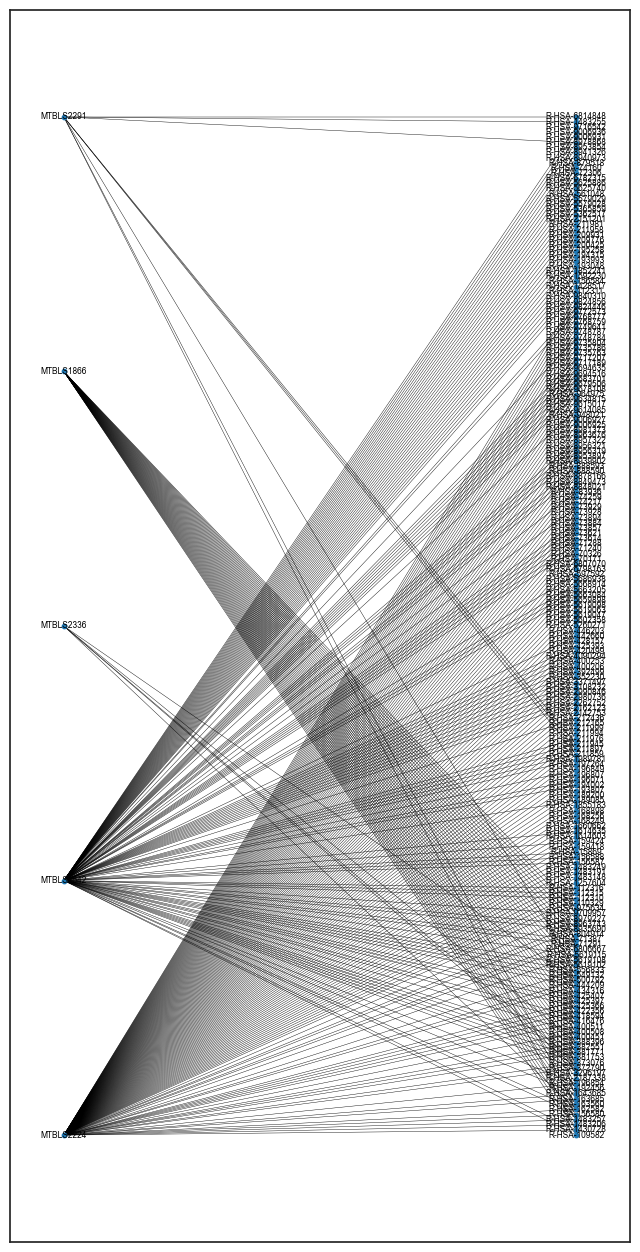

In [20]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    covid_bpt,
    pos = nx.drawing.layout.bipartite_layout(covid_bpt, covid_bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()


MTBLS1866
MTBLS2224
MTBLS2542
MTBLS2291
MTBLS2336


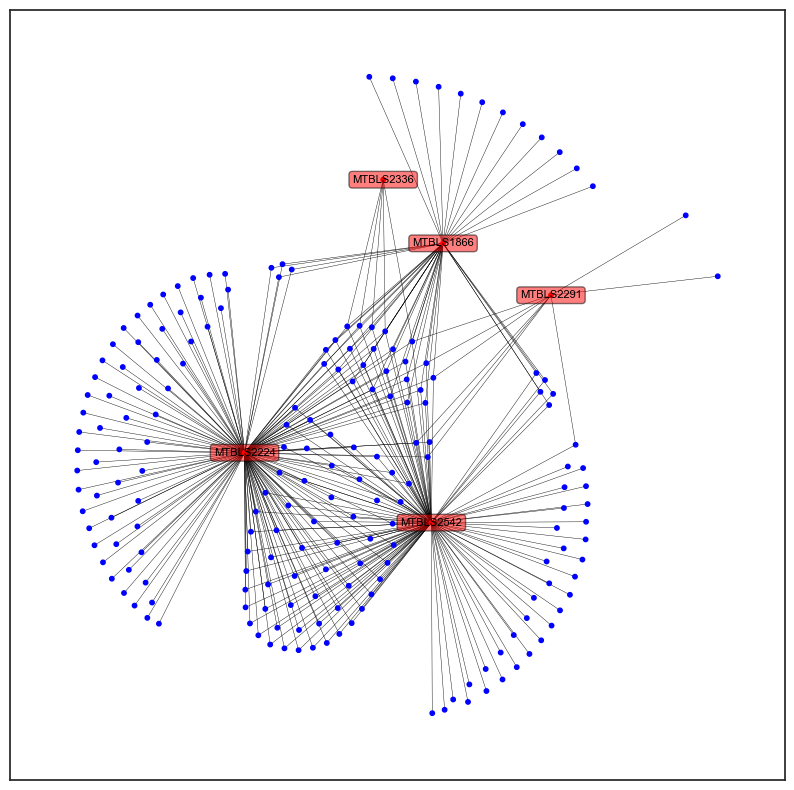

In [21]:

# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(covid_bpt)
color_map = []
labels = {}
for node in covid_bpt:
    if node in covid_bottom_nodes:
        print(node)
        color_map.append('red')
        labels[node] = node
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    covid_bpt,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like
nx.draw_networkx_labels(covid_bpt, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')

plt.show()

In [22]:
biadj_mat = nx.bipartite.biadjacency_matrix(covid_bpt, row_order=covid_bottom_nodes, column_order=covid_top_nodes).toarray()


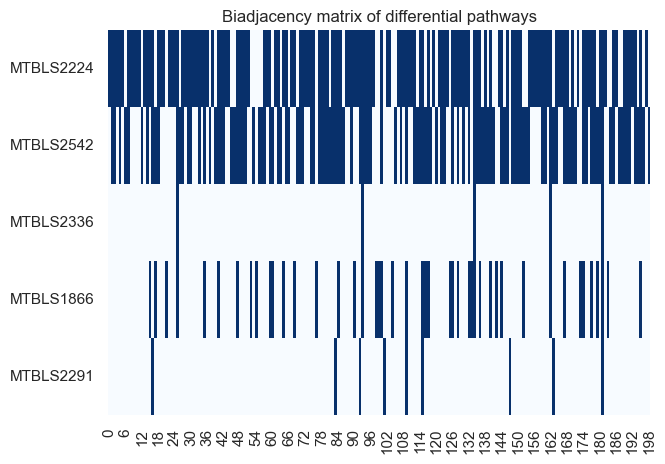

In [23]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(biadj_mat, cmap='Blues', cbar=False)
ax.set_yticklabels(covid_bottom_nodes, rotation=0)
ax.set_title('Biadjacency matrix of differential pathways')
plt.show()


In [24]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(covid_bottom_nodes), columns=list(covid_bottom_nodes))


c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


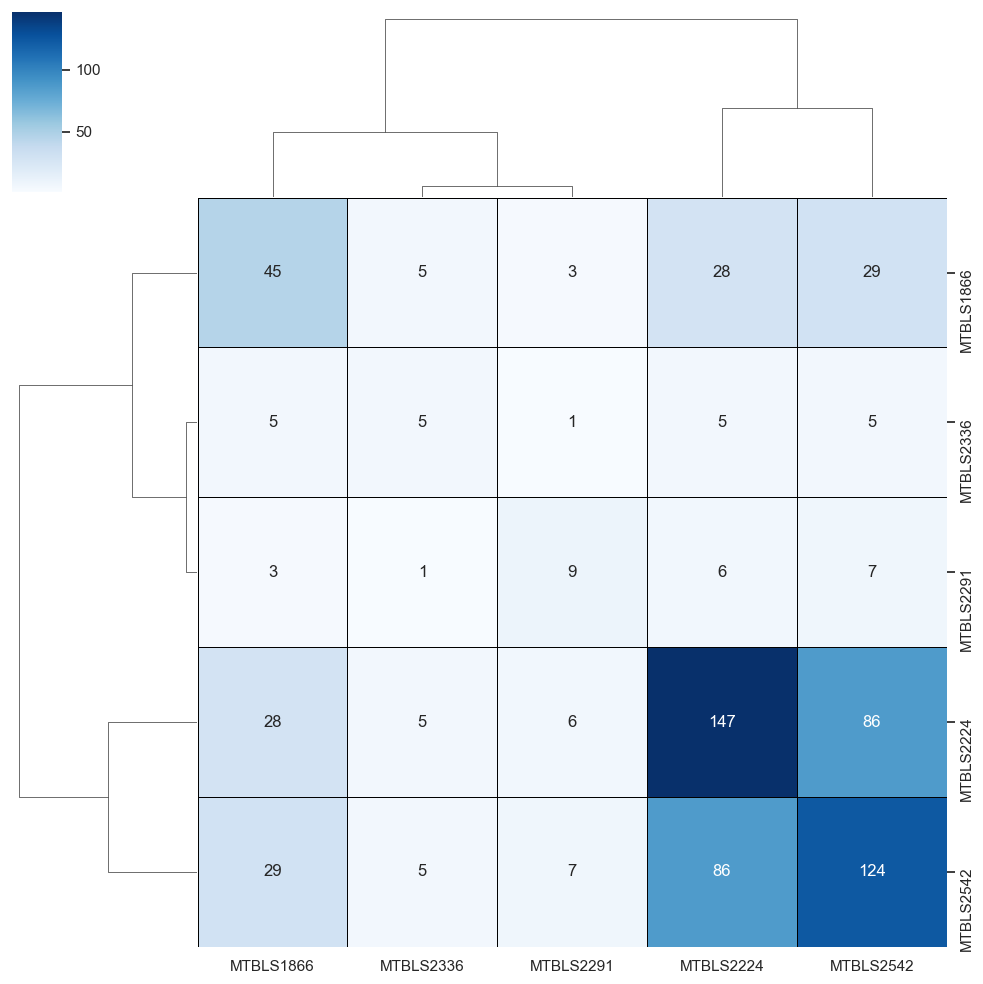

In [25]:

# fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style='white')
sns.clustermap(
    adj_mat, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )
# ax.set_yticklabels(bottom_nodes, rotation=0)
# ax.set_xticklabels(bottom_nodes, rotation=90)
ax.set_title('Similarity matrix of differential pathways')
# plt.tight_layout()
plt.show()


## Disease-metabolite network

In [26]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn = pd.DataFrame(biadj_mat.T @ biadj_mat, index=list(covid_top_nodes), columns=list(covid_top_nodes))


In [27]:
adj_mat_dmn

,R-HSA-8981373,R-HSA-71240,R-HSA-4090294,R-HSA-5619047,R-HSA-352230,R-HSA-74217,R-HSA-5579029,R-HSA-73621,R-HSA-1483148,R-HSA-5619063,...,R-HSA-112316,R-HSA-597592,R-HSA-83936,R-HSA-9749641,R-HSA-400206,R-HSA-211981,R-HSA-8935690,R-HSA-5365859,R-HSA-8849473,R-HSA-195258
R-HSA-8981373,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,0,1,0,1,0
R-HSA-71240,1,2,2,1,2,1,1,2,1,1,...,2,2,2,1,2,1,2,1,1,1
R-HSA-4090294,1,2,2,1,2,1,1,2,1,1,...,2,2,2,1,2,1,2,1,1,1
R-HSA-5619047,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,0,1,0,1,0
R-HSA-352230,1,2,2,1,2,1,1,2,1,1,...,2,2,2,1,2,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-HSA-211981,0,1,1,0,1,0,1,1,0,0,...,1,1,1,0,1,1,1,1,0,1
R-HSA-8935690,1,2,2,1,2,1,1,2,1,1,...,2,2,2,1,2,1,3,1,1,1
R-HSA-5365859,0,1,1,0,1,0,1,1,0,0,...,1,1,1,0,1,1,1,1,0,1
R-HSA-8849473,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,0,1,0,1,0


In [28]:

# make pandas edgelist
edgelist_dmn = adj_mat_dmn.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 1]


In [29]:
edgelist_dmn.sort_values('weight', ascending=False)

,source,target,weight
36200,R-HSA-162582,R-HSA-162582,5
36153,R-HSA-162582,R-HSA-388396,4
32372,R-HSA-500792,R-HSA-388396,4
18669,R-HSA-373076,R-HSA-500792,4
26691,R-HSA-388396,R-HSA-372790,4
...,...,...,...
15512,R-HSA-420499,R-HSA-112316,2
15508,R-HSA-420499,R-HSA-888593,2
15504,R-HSA-420499,R-HSA-162582,2
15503,R-HSA-420499,R-HSA-5668914,2


In [30]:
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')


In [31]:
print(dmn_graph.number_of_nodes())
print(dmn_graph.number_of_edges())


96
3893


In [32]:
nx.density(dmn_graph)

0.8537280701754386

In [33]:
nx.average_clustering(dmn_graph)

0.9657213053551578

In [34]:
len(nx.community.louvain_communities(dmn_graph))

2

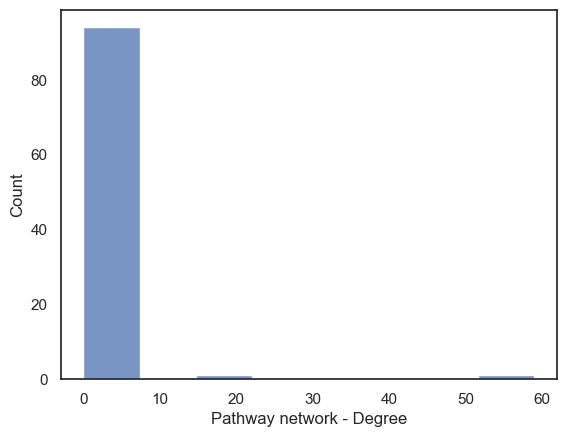

In [35]:
sns.histplot(nx.degree_histogram(dmn_graph))
plt.xlabel('Pathway network - Degree')
plt.show()

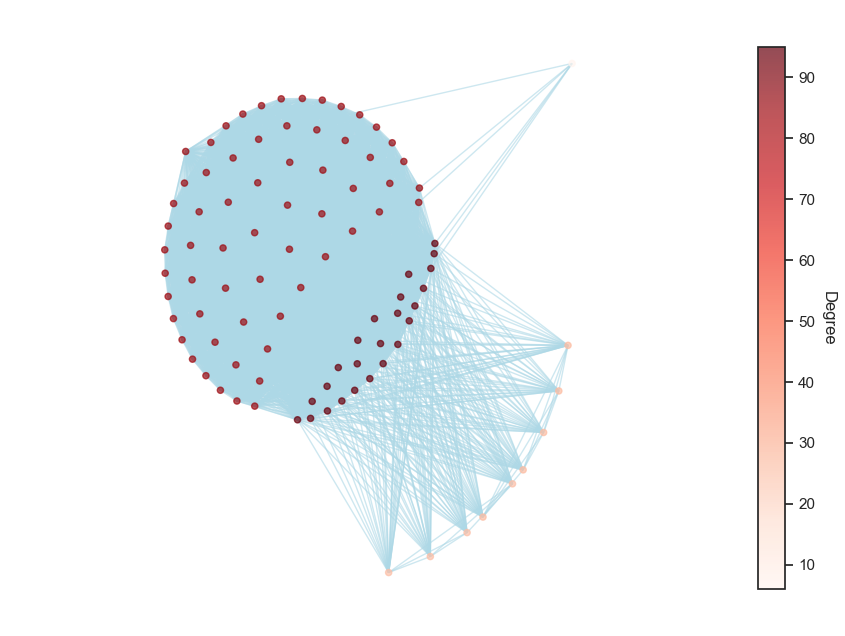

In [36]:

widths = nx.get_edge_attributes(dmn_graph, 'weight')
nodelist = dmn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(dmn_graph)
nds = nx.draw_networkx_nodes(dmn_graph,pos,
                       nodelist=nodelist,
                       node_size=20,
                       node_color=list(nx.get_node_attributes(dmn_graph, 'degree').values()),
                       cmap='Reds',
                       alpha=0.7)
nx.draw_networkx_edges(dmn_graph,pos,
                       edgelist = widths.keys(),
                       edge_color='lightblue',
                       alpha=0.6)

# Add a colorbar
cbar = plt.colorbar(nds, fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Degree', rotation=-90, va="bottom")

plt.box(False)
plt.margins(x=0.3)
plt.show()


In [37]:
# get pathway names
reactome = sspa.process_gmt('Reactome_Homo_sapiens_pathways_ChEBI_R90.gmt')
pathway_names = dict(zip(reactome.index, reactome['Pathway_name']))

In [38]:
nx.set_node_attributes(dmn_graph, pathway_names, 'name')
# nx.set_node_attributes(dmn_graph, chebi_mass, 'mass')

In [39]:
biadj_mat_df = pd.DataFrame(biadj_mat, index=list(covid_bottom_nodes), columns=list(covid_top_nodes))

In [40]:
study_contributions = biadj_mat_df.divide(biadj_mat_df.sum(axis=0), axis=1)
# add contribution from each study 
nx.set_node_attributes(dmn_graph, study_contributions.to_dict())

In [41]:
# total pathway size
reactome_dict = sspa.utils.pathwaydf_to_dict(reactome)
reactome_size = {k: len(v) for k, v in reactome_dict.items()}

In [42]:
# add average pathway coverage (over 1)
coverage_dicts = [i.pathway_coverage for i in studies]

# make dataframe
coverage_df = pd.concat([pd.Series(i) for i in coverage_dicts], axis=1)
coverage_df.columns = [i.id + '_coverage' for i in studies]


In [43]:
coverage_df

,MTBLS1866_coverage,MTBLS2224_coverage,MTBLS2542_coverage,MTBLS2291_coverage,MTBLS2336_coverage
R-HSA-1059683,0,0,0,0,0
R-HSA-109581,0,0,0,0,0
R-HSA-109582,2,3,2,0,1
R-HSA-109606,0,0,0,0,0
R-HSA-109703,0,0,0,0,0
...,...,...,...,...,...
R-HSA-9918443,0,0,0,0,0
R-HSA-9918449,0,0,0,0,0
R-HSA-9918450,0,0,0,0,0
R-HSA-9918454,0,0,0,0,0


In [44]:
coverage_df = coverage_df.divide(reactome_size.values(), axis=0)


In [45]:
coverage_df = coverage_df * 100

In [46]:
coverage_df.max()

MTBLS1866_coverage    50.0
MTBLS2224_coverage    60.0
MTBLS2542_coverage    80.0
MTBLS2291_coverage    30.0
MTBLS2336_coverage    25.0
dtype: float64

In [47]:

# add attributes
nx.set_node_attributes(dmn_graph, coverage_df.median(axis=1).to_dict(), name='median_coverage_pct')


c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


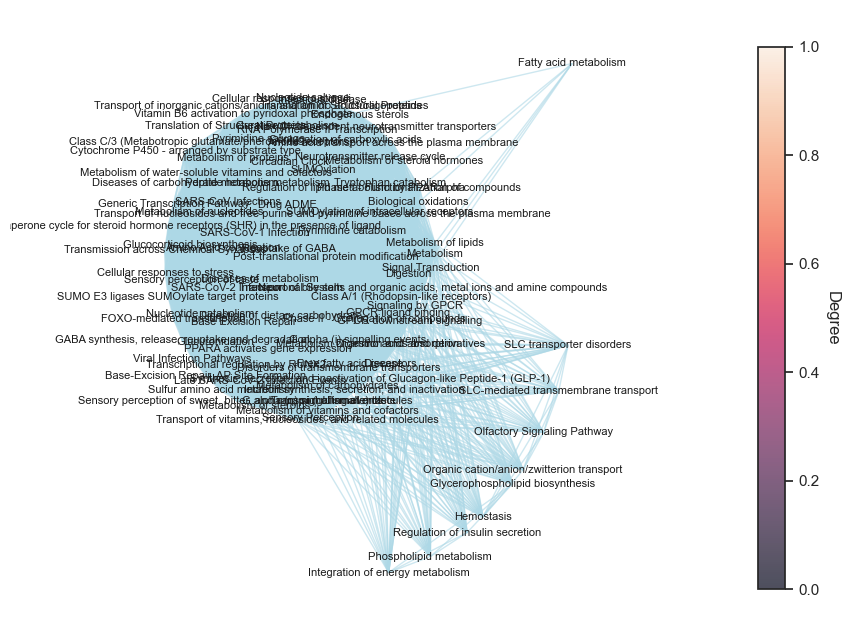

In [48]:

widths = nx.get_edge_attributes(dmn_graph, 'weight')
nodelist = dmn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(dmn_graph)
nds = nx.draw_networkx_nodes(dmn_graph,pos,
                       nodelist=nodelist,
                       node_size=list(nx.get_node_attributes(dmn_graph, 'degree').values()),
                       node_color=list(nx.get_node_attributes(dmn_graph, 'mass').values()),
                       cmap='Greens',
                       alpha=0.7)
nx.draw_networkx_edges(dmn_graph,pos,
                       edgelist = widths.keys(),
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(dmn_graph, pos, labels=nx.get_node_attributes(dmn_graph, 'name'), font_size=8)

# Add a colorbar
cbar = plt.colorbar(nds, fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Degree', rotation=-90, va="bottom")

plt.box(False)
plt.margins(x=0.3)
plt.show()


In [49]:
nx.write_graphml(dmn_graph, 'covid_pathways_network.graphml')